# Проект курса "Численные методы"

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

Признаки:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:

- Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('/datasets/autos.csv')
df[:3]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Предобработка

Удалим колонки, не влияющие на стоимость автомобиля:

In [4]:
df = df.drop(['DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures'], axis = 1)
df[:3]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN


Найдем колонки с пропусками:

In [5]:
cols = df.isna().mean().sort_values(ascending=False).reset_index()
cols = cols[cols[0] > 0]
cols_with_missing = cols['index'].values
cols_with_missing

array(['NotRepaired', 'VehicleType', 'FuelType', 'Gearbox', 'Model'],
      dtype=object)

Данные колонки содержат категориальные признаки, поэтому пропуски заменим на отдельную категорию ‘unknown’

In [6]:
df[cols_with_missing] = df[cols_with_missing].fillna('unknown')
df[cols_with_missing].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   NotRepaired  354369 non-null  object
 1   VehicleType  354369 non-null  object
 2   FuelType     354369 non-null  object
 3   Gearbox      354369 non-null  object
 4   Model        354369 non-null  object
dtypes: object(5)
memory usage: 13.5+ MB


Проверим числовые признаки:

In [7]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645
std,4514.158514,90.227958,189.850405,37905.341530,3.726421
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


В столбце RegistrationYear присутствуют аномальные значения, поэтому установим границы - год регистрации не может быть больше ~~2020~~2016, и не может быть меньше 1930

In [8]:
def Balance_RegistrationYear(value):
    if value > 2016:
        return 2016
    elif value < 1930:
        return 1930
    else:
        return value
df["RegistrationYear"] = df["RegistrationYear"].apply(Balance_RegistrationYear)

В колонке Power присутствуют аномальные значения (20 000 лошадиных сил), ограничим их мощностью БелАЗ(а), т.е. 3500

In [9]:
df.loc[df['Power'] > 3500, 'Power'] = 3500

**Значения из столбца Price обладают высоким стандартным отклонениям, что пагубно будет влиять на работу алгоритма. Найдем и очистим признак от выбросов**

4416.656775846645

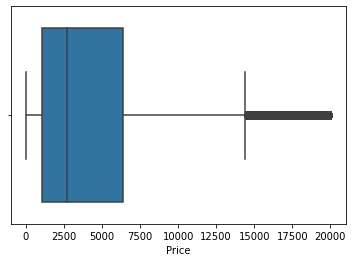

In [10]:
sns.boxplot(x=df['Price'])
df.Price.mean()

In [11]:
q25=np.array(df['Price'].quantile(0.25))
q75=np.array(df['Price'].quantile(0.75))
first_part=q25-1.5*(q75-q25)
second_part=q75+1.5*(q75-q25)
del_index = []
for index_value, value in zip(df['Price'].index,df['Price']):
    if second_part <= value or value <= first_part:
        del_index.append(index_value)
df = df.drop(del_index,axis = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335390 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              335390 non-null  int64 
 1   VehicleType        335390 non-null  object
 2   RegistrationYear   335390 non-null  int64 
 3   Gearbox            335390 non-null  object
 4   Power              335390 non-null  int64 
 5   Model              335390 non-null  object
 6   Kilometer          335390 non-null  int64 
 7   RegistrationMonth  335390 non-null  int64 
 8   FuelType           335390 non-null  object
 9   Brand              335390 non-null  object
 10  NotRepaired        335390 non-null  object
dtypes: int64(5), object(6)
memory usage: 30.7+ MB


### One Hot Encoding

С помощью техники OHE подготовим данные из категориальных столбцов. Используем параметр drop_first=True, чтобы избежать дамми-ловушки.

In [12]:
cols_for_ohe = np.array(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'])
cols_for_ohe

array(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand',
       'NotRepaired'], dtype='<U11')

In [13]:
df_ohe = pd.get_dummies(df, columns = cols_for_ohe, drop_first=True)
print('Количество признаков после OHE:', df_ohe.columns.values.size)

Количество признаков после OHE: 313


Разделение выборок

Разделим выборки на обучающую, тестовую и валидационную

In [14]:
features = df_ohe.drop(['Price'], axis=1)
target = df_ohe['Price']

features_train, features_temp, target_train, target_temp = train_test_split(
    features, target, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_temp, target_temp, test_size=0.5, random_state=12345)

In [15]:
print('Размер выборки _train', features_train.shape)
print('Размер выборки _valid', features_valid.shape)
print('Размер выборки _test', features_test.shape)

Размер выборки _train (201234, 312)
Размер выборки _valid (67078, 312)
Размер выборки _test (67078, 312)


## Обучение моделей

### RandomForest



Перед использованием градиентного бустинга попробуем более простую модель - RandomForest. Используем поиск гиперпараметоров с помощью GridSearchCV

In [22]:
start = time.time()
model = RandomForestRegressor()
params = {
    'n_estimators' : [10, 20, 30],
    'max_depth' : [3, 5, 10],
    'random_state' : [12345]
    }
grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_cv.fit(features_train, target_train)
end = time.time()
time_fit_rf_cv = end - start
rf_params = grid_cv.best_params_
rf_rmse = (-grid_cv.best_score_) ** 0.5
print('Best hyperparams: ', rf_params)
print('Train RMSE: {:.2f}'.format(rf_rmse))
print('Time: {:.2f}'.format(time_fit_rf_cv))

Best hyperparams:  {'max_depth': 10, 'n_estimators': 30, 'random_state': 12345}
Train RMSE: 1709.97
Time: 603.44


In [32]:
start = time.time()
model_rf = RandomForestRegressor(**rf_params)
model_rf.fit(features_train, target_train)
end = time.time()
time_fit_rf = end - start

start = time.time()
predict_rf = model_rf.predict(features_valid)
end = time.time()
time_pred_rf = end - start

rmse_rf = mean_squared_error(target_valid, predict_rf)**0.5

print('Test RMSE = {:.2f}'.format(rmse_rf))
print('Time Fit: {:.2f}'.format(time_fit_rf))
print('Time Predict: {:.2f}'.format(time_pred_rf))

Test RMSE = 1706.43
Time Fit: 79.76
Time Predict: 0.31


### LightGBM

In [28]:
start = time.time()
model = LGBMRegressor()
params = {
    'boosting_type' : ['gbdt'],
    'n_estimators' : [50, 100, 200],
    'max_depth' : [5, 7, 10],
    'verbose' : [-1],
    'random_state' : [12345],
    'force_col_wise': [True],
    'num_leaves' : [30, 130, 200]
    }
grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_cv.fit(features_train, target_train)
end = time.time()
time_fit_lgb_cv = end - start
lgb_params = grid_cv.best_params_
lgb_rmse = (-grid_cv.best_score_) ** 0.5
print('Best hyperparams: ', lgb_params)
print('Train RMSE: {:.2f}'.format(lgb_rmse))
print('Time: {:.2f}'.format(time_fit_lgb_cv))

Best hyperparams:  {'boosting_type': 'gbdt', 'force_col_wise': True, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 200, 'random_state': 12345, 'verbose': -1}
Train RMSE: 1475.92
Time: 685.09


In [29]:
start = time.time()
model_lgb = LGBMRegressor(**lgb_params)
model_lgb.fit(features_train, target_train)#, eval_set=(X_test, y_test), verbose=10, eval_metric='rmse')
end = time.time()
time_fit_lgb = end - start

start = time.time()
predict_lgb = model_lgb.predict(features_valid)
end = time.time()
time_pred_lgb = end - start

rmse_lgb = mean_squared_error(target_valid, predict_lgb)**0.5

print('Test RMSE = {:.2f}'.format(rmse_lgb))
print('Time Fit: {:.2f}'.format(time_fit_lgb))
print('Time Predict: {:.2f}'.format(time_pred_lgb))

Test RMSE = 1464.21
Time Fit: 21.39
Time Predict: 1.61


## Анализ моделей

In [33]:
results = {
    'Model' : ['LGBMRegressor_CV', 'LGBMRegressor_best','RandomForest_CV', 'RandomForest_best'],
    'Train Time, sec': pd.Series([time_fit_lgb_cv, time_fit_lgb, time_fit_rf_cv, time_fit_rf]),
    'Test Time, sec': pd.Series(['-', time_pred_lgb, '-', time_pred_rf]),
    'Test RMSE' :pd.Series([lgb_rmse, rmse_lgb, rf_rmse, rmse_rf]),
    }
display(pd.DataFrame(results))

,Model,"Train Time, sec","Test Time, sec",Test RMSE
0,LGBMRegressor_CV,685.087549,-,1475.922200
1,LGBMRegressor_best,21.390705,1.614829,1464.209895
2,RandomForest_CV,603.437137,-,1709.974236
3,RandomForest_best,79.762338,0.309591,1706.428506


In [31]:
predict_lgb_test = model_lgb.predict(features_test)
rmse_lgb_test = mean_squared_error(target_test, predict_lgb_test)**0.5
rmse_lgb_test

1444.1664996679585

**Выводы:** 
- Наилучший RMSE у LGBMRegressor с найденными лучшими гиперпараметрами. 
- Самая быстрая модель LGBMRegressor.
- Лучшая модель успешно прошла тестирование с RMSE = 1444